# Heart diseases prediction

## Предобработка данных

In [1]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Осмотрим имеющиеся данные

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


In [7]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


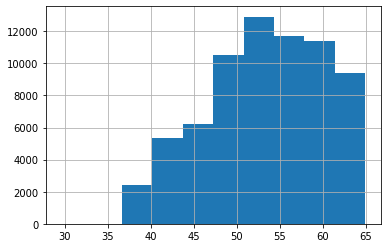

In [9]:
(df['age']/365).hist()

Пропуски остутствуют. Можно отметить, что значения в столбце 'age', вероятнее всего, означают количество дней между рождением пациента и выгрузкой данных, так как при делении на 365 данные становятся похожи на реальный возраст людей в годах. Заменим этот столбец на целочисленный возраст в годах.

In [10]:
df['years'] = (df['age'] / 365).astype(int)
df_test['years'] = (df_test['age'] / 365).astype(int)

In [11]:
df = df.drop('age', axis=1)
df_test = df_test.drop('age', axis=1)

Данные в столбце 'weight' тоже заменим на целочисленные. ID пациента назначим индексом данных.

In [12]:
df['weight'] = df['weight'].astype(int)
df_test['weight'] = df_test['weight'].astype(int)

In [13]:
df = df.set_index('id')
df_test = df_test.set_index('id')

Изучим распределение признаков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a6363e990>,
      dtype=object)

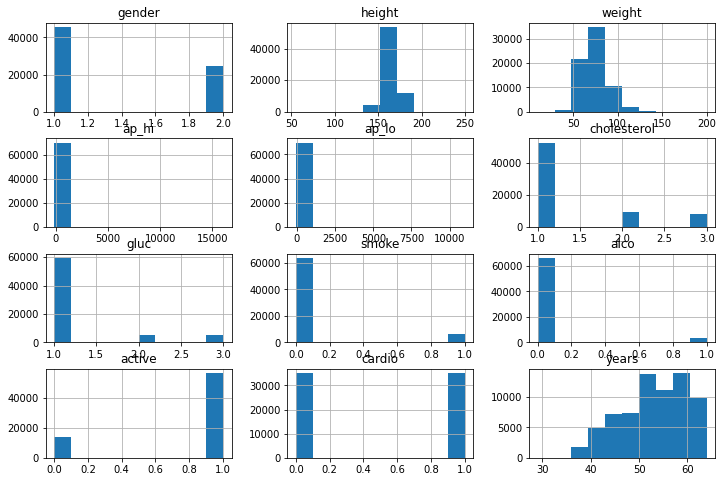

In [14]:
df.hist(figsize=(12,8))

In [15]:
for i in ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']:
  print(i)
  print(df[i].value_counts())

gender
1    45530
2    24470
Name: gender, dtype: int64
cholesterol
1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64
gluc
1    59479
3     5331
2     5190
Name: gluc, dtype: int64
smoke
0    63831
1     6169
Name: smoke, dtype: int64
alco
0    66236
1     3764
Name: alco, dtype: int64
active
1    56261
0    13739
Name: active, dtype: int64


Признаки 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active' принимают от двух до трех значений и не имеют выбросов

Очистим от выбросов признаки 'height', 'weight', 'ap_hi', 'ap_lo'. Для это были применены разные техники, такие как удаление данных за пределами n-квантиля и удаление данных за пределами полуторакратного межквартильного расстояния. Но на практике наилучшее улучшение предсказаний модели показало ручное удаление выбросов, основанное на визуальном осмотре данных и понимании их адекватности к реальной жизни.

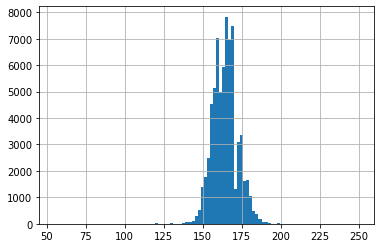

In [16]:
df['height'].hist(bins=100)

Значения ниже 130 см и выше 200 см заменим на медианный рост пациентов.

In [17]:
median_height = df.height.median()

In [18]:
def height_median(row):
  if row['height'] < 130 or row['height'] > 200:
    return int(median_height)
  return int(row['height'])

In [19]:
df['height'] = df.apply(height_median, axis=1)
df_test['height'] = df_test.apply(height_median, axis=1)

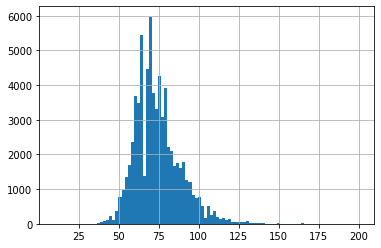

In [20]:
df['weight'].hist(bins=100)

Значения ниже 35 кг и выше 170 кг заменим на медианный вес пациентов.

In [21]:
median_weight = df.weight.median()

In [22]:
def weight_median(row):
  if row['weight'] < 35 or row['weight'] > 170:
    return int(median_weight)
  return int(row['weight'])

In [23]:
df['weight'] = df.apply(weight_median, axis=1)
df_test['weight'] = df_test.apply(weight_median, axis=1)

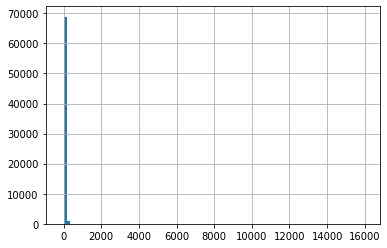

In [24]:
df['ap_hi'].hist(bins=100)

Увеличим масштаб

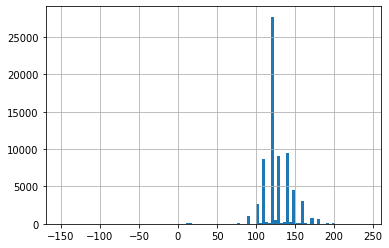

In [25]:
df[df['ap_hi']<300]['ap_hi'].hist(bins=100)

Значения ниже 70 и выше 200 заменим на медиану.

In [26]:
median_ap_hi = df.ap_hi.median()

In [27]:
def ap_hi_median(row):
  if row['ap_hi'] < 70 or row['ap_hi'] > 200:
    return int(median_ap_hi)
  return int(row['ap_hi'])

In [28]:
df['ap_hi'] = df.apply(ap_hi_median, axis=1)
df_test['ap_hi'] = df_test.apply(ap_hi_median, axis=1)

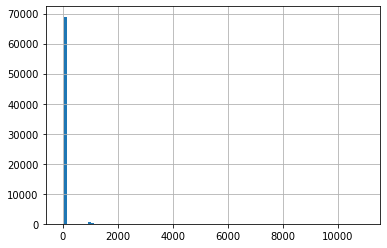

In [29]:
df['ap_lo'].hist(bins=100)

Увеличим масштаб

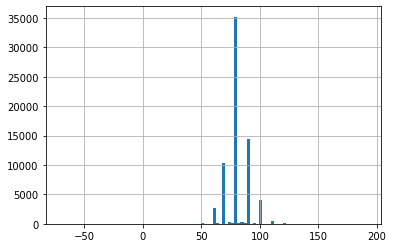

In [30]:
df[df['ap_lo']<300]['ap_lo'].hist(bins=100)

Значения ниже 50 и выше 150 заменим на медиану.

In [31]:
median_ap_lo = df.ap_lo.median()

In [32]:
def ap_lo_median(row):
  if row['ap_lo'] < 50 or row['ap_lo'] > 150:
    return int(median_ap_lo)
  return int(row['ap_lo'])

In [33]:
df['ap_lo'] = df.apply(ap_lo_median, axis=1)
df_test['ap_lo'] = df_test.apply(ap_lo_median, axis=1)

## Feature engineering

Визуализируем данные в формате pairplot с подсвечиванием данных по целевому признаку, чтобы проанализировать распределение разных групп по имеющимся признакам

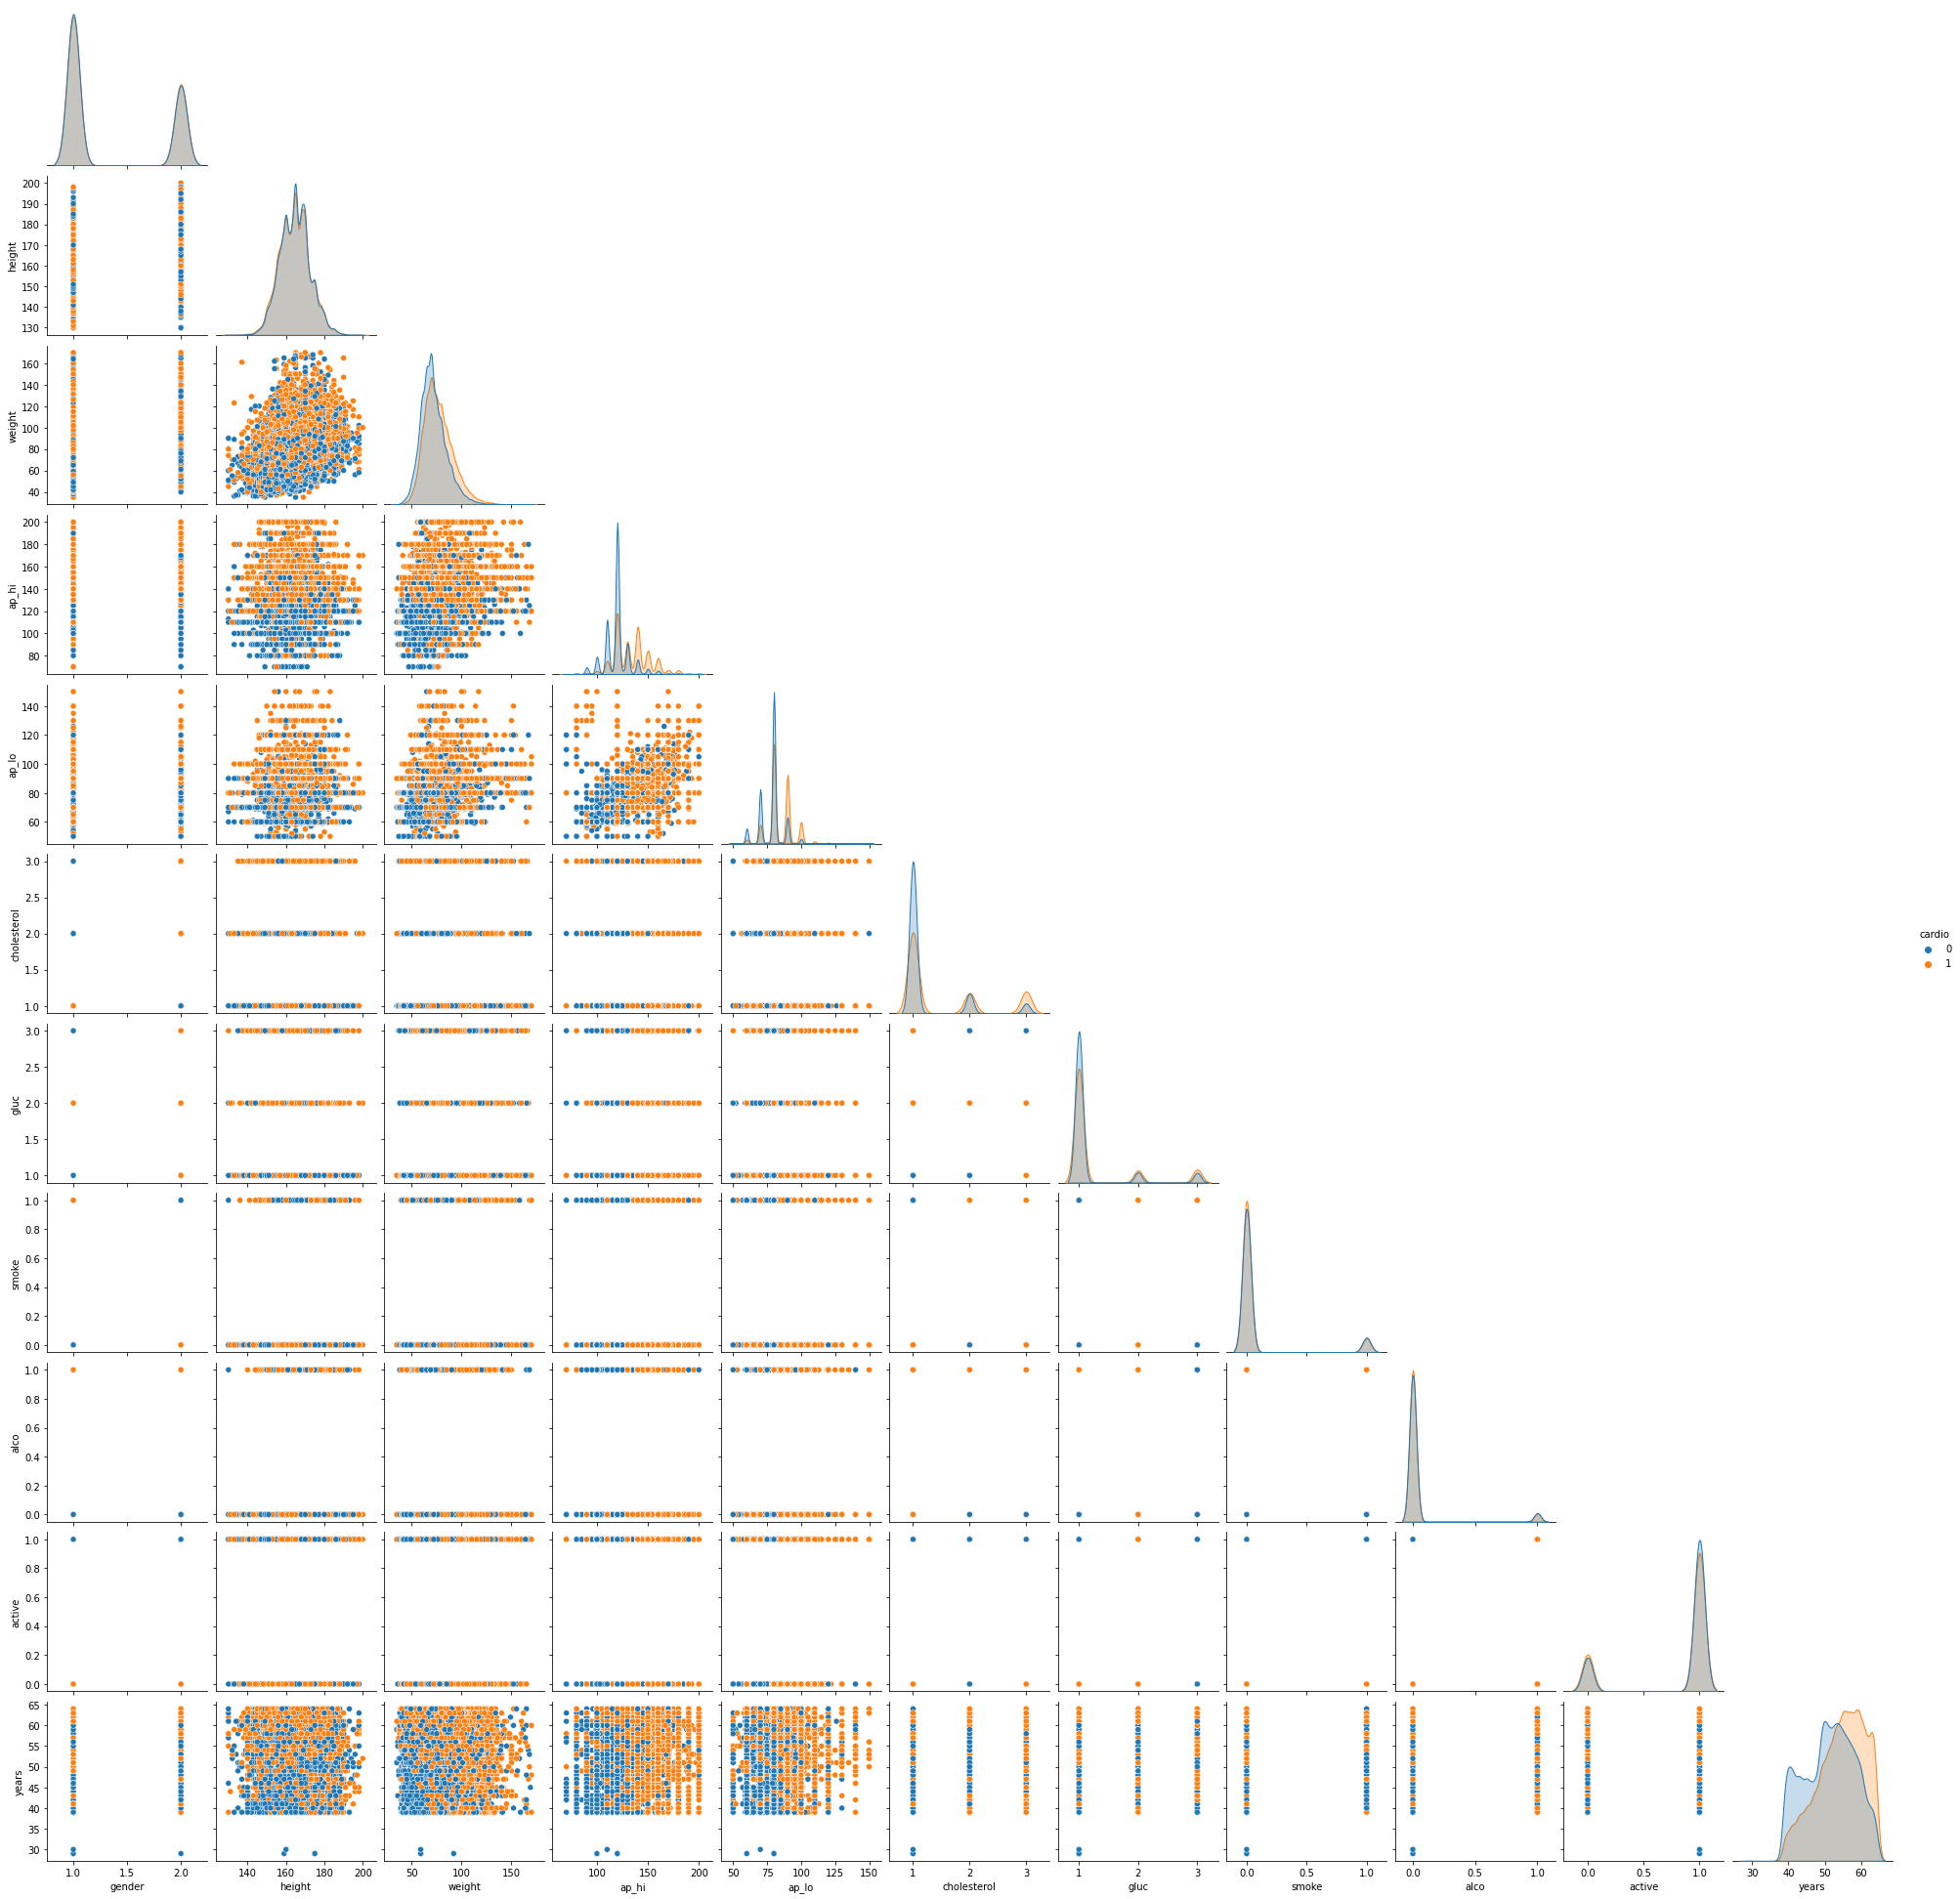

In [34]:
sns.pairplot(data=df, hue='cardio', corner=True)

На диаграмме можно заметить, что на графике распределения в координатах 'weight' и 'years' чем дальше точки от начала координат, тем больше среди них принимают значение 'cardio' = 1. Добавим искусственный признак, который будет представлять из себя произведение веса человека на его возраст

In [35]:
df['weight*years'] = df['years']*df['weight']
df_test['weight*years'] = df_test['years']*df_test['weight']

## Разделение данных на выборки

In [36]:
features = df.drop('cardio', axis=1)
target = df['cardio']

Выделим валидационную часть, на которой будем проверять наши модели

In [37]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2)

## Обучение моделей

Проверим работу нескольких видов моделей, к лучшим из них подберем оптимальные гиперпараметры

### LogisticRegression

Для модели логистической регрессии нужно нормализовать данные

In [38]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_std = scaler.transform(features_train)
features_valid_std = scaler.transform(features_valid)

In [39]:
lr_model = LogisticRegression()
lr_model.fit(features_train_std, target_train)
lr_valid_proba = lr_model.predict_proba(features_valid_std)[:,1]
lr_roc_auc = roc_auc_score(target_valid, lr_valid_proba)
print('ROC-AUC модели линейной регрессии на валидационной выборке составляет {}'.format(lr_roc_auc))

ROC-AUC модели линейной регрессии на валидационной выборке составляет 0.793652587496505


### RandomForest

In [40]:
%%time
rf_model = RandomForestClassifier()
rf_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40)
}
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
rf_grid_search.fit(features_train, target_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
CPU times: user 16min 30s, sys: 4.67 s, total: 16min 34s
Wall time: 16min 32s


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 13, 2),
                         'n_estimators': range(40, 201, 40)},
             scoring='roc_auc', verbose=True)

In [41]:
rf_valid_proba = rf_grid_search.best_estimator_.predict_proba(features_valid)[:,1]
rf_roc_auc = roc_auc_score(target_valid, rf_valid_proba)
print('ROC-AUC модели случайного леса на валидационной выборке составляет {}'.format(rf_roc_auc))

ROC-AUC модели случайного леса на валидационной выборке составляет 0.8040727482749683


### KNeighbors

In [42]:
%%time
knn_model = KNeighborsClassifier()
knn_parameters = {
    'n_neighbors': range(5, 31, 5)
}
knn_grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
knn_grid_search.fit(features_train, target_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
CPU times: user 16.2 s, sys: 79.5 ms, total: 16.3 s
Wall time: 16.2 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 31, 5)}, scoring='roc_auc',
             verbose=True)

In [43]:
knn_valid_proba = knn_grid_search.best_estimator_.predict_proba(features_valid)[:,1]
knn_roc_auc = roc_auc_score(target_valid, knn_valid_proba)
print('ROC-AUC модели k-ближайших соседей на валидационной выборке составляет {}'.format(knn_roc_auc))

ROC-AUC модели k-ближайших соседей на валидационной выборке составляет 0.7753385368302682


### XGBoost

In [44]:
%%time
xgb_model = XGBClassifier(
    objective='binary:logistic'
)
xgb_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40),
    'learning_rate': [0.1, 0.05, 0.01]
}
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
xgb_grid_search.fit(features_train, target_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU times: user 1h 59min 19s, sys: 15.3 s, total: 1h 59min 34s
Wall time: 1h 59min 10s


GridSearchCV(cv=10, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': range(2, 13, 2),
                         'n_estimators': range(40, 201, 40)},
             scoring='roc_auc', verbose=True)

In [45]:
xgb_valid_proba = xgb_grid_search.best_estimator_.predict_proba(features_valid)[:,1]
xgb_roc_auc = roc_auc_score(target_valid, xgb_valid_proba)
print('ROC-AUC модели XGBoost на валидационной выборке составляет {}'.format(xgb_roc_auc))

ROC-AUC модели XGBoost на валидационной выборке составляет 0.8048414460673767


### CatBoost

In [46]:
%%time
cb_model = CatBoostClassifier(loss_function='Logloss', 
                              verbose=False)
cb_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40),
    'learning_rate': [0.1, 0.05, 0.01],
}    
cb_grid_search = GridSearchCV(
    estimator=cb_model,
    param_grid=cb_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
cb_grid_search.fit(features_train, target_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU times: user 1h 2min 33s, sys: 1min 38s, total: 1h 4min 11s
Wall time: 36min 1s


GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f8a60bfa350>,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': range(2, 13, 2),
                         'n_estimators': range(40, 201, 40)},
             scoring='roc_auc', verbose=True)

In [47]:
cb_valid_proba = cb_grid_search.best_estimator_.predict_proba(features_valid)[:,1]
cb_roc_auc = roc_auc_score(target_valid, cb_valid_proba)
print('ROC-AUC модели CatBoost на валидационной выборке составляет {}'.format(cb_roc_auc))

ROC-AUC модели CatBoost на валидационной выборке составляет 0.8050615215381507


### LightGBM

In [48]:
%%time
lgb_model = LGBMClassifier()
lgb_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40),
    'learning_rate': [0.1, 0.05, 0.01]
}
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
lgb_grid_search.fit(features_train, target_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU times: user 12min 55s, sys: 8.09 s, total: 13min 3s
Wall time: 13min 1s


GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': range(2, 13, 2),
                         'n_estimators': range(40, 201, 40)},
             scoring='roc_auc', verbose=True)

In [49]:
lgb_valid_proba = lgb_grid_search.best_estimator_.predict_proba(features_valid)[:,1]
lgb_roc_auc = roc_auc_score(target_valid, lgb_valid_proba)
print('ROC-AUC модели LightGBM на валидационной выборке составляет {}'.format(lgb_roc_auc))

ROC-AUC модели LightGBM на валидационной выборке составляет 0.8047664548940694


### Анализ результатов работы моделей

Сведем результаты работы моделей в одну таблицу

In [50]:
pd.DataFrame({'Model':['LogisticRegression', 'RandomForest', 'KNeighbors', 'XGBoost', 'CatBoost', 'LightGBM'],
              'ROC-AUC':[lr_roc_auc, rf_roc_auc, knn_roc_auc, xgb_roc_auc, cb_roc_auc, lgb_roc_auc]}).sort_values(by='ROC-AUC', ascending=False)

,Model,ROC-AUC
4,CatBoost,0.805062
3,XGBoost,0.804841
5,LightGBM,0.804766
1,RandomForest,0.804073
0,LogisticRegression,0.793653
2,KNeighbors,0.775339


Как видно из таблицы, наилучший результат показали модели градиентного бустинга. Попробуем усреднить предсказания этих моделей и посчитать ROC-AUC.

In [51]:
mean_valid_proba = (xgb_valid_proba + cb_valid_proba + lgb_valid_proba) / 3
mean_valid_roc_auc = roc_auc_score(target_valid, mean_valid_proba)
print('ROC-AUC среднего от предсказаний моделей градиентного бустинга на валидационной выборке составляет {}'.format(mean_valid_roc_auc))

ROC-AUC среднего от предсказаний моделей градиентного бустинга на валидационной выборке составляет 0.8054313140445437


Интересно, что качество среднего предсказания моделей выше, чем их предсказания по отдельности. Вероятно, это связано с тем, что для каждого объекта предсказания в случае ошибки одной модели ее компенсируют предсказания двух других.

Снова обучим модели на полном датасете, чтобы увеличить качество обучения, затем усредним их показания для тестовой выборки.

*На практике были опробованы ансамбли из различных комбинаций моделей, но наилучший результат показал ансамбль моделей градиентного бустинга.*

## Обучение моделей на всём датасете и Model Ensembling

XGBoost

In [52]:
%%time
xgb_model = XGBClassifier(
    objective='binary:logistic'
)
xgb_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40),
    'learning_rate': [0.1, 0.05, 0.01]
}
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
xgb_grid_search.fit(features, target)
xgb_test_proba = xgb_grid_search.best_estimator_.predict_proba(df_test)[:,1]

Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU times: user 2h 29min 46s, sys: 18.5 s, total: 2h 30min 4s
Wall time: 2h 29min 27s


CatBoost

In [53]:
%%time
cb_model = CatBoostClassifier(loss_function='Logloss', 
                              verbose=False)
cb_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40),
    'learning_rate': [0.1, 0.05, 0.01],
}    
cb_grid_search = GridSearchCV(
    estimator=cb_model,
    param_grid=cb_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
cb_grid_search.fit(features, target)
cb_test_proba = cb_grid_search.best_estimator_.predict_proba(df_test)[:,1]

Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU times: user 1h 12min 21s, sys: 1min 52s, total: 1h 14min 13s
Wall time: 41min 33s


LightGBM

In [54]:
%%time
lgb_model = LGBMClassifier()
lgb_parameters = {
    'max_depth': range(2, 13, 2),
    'n_estimators': range(40, 201, 40),
    'learning_rate': [0.1, 0.05, 0.01]
}
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_parameters,
    scoring = 'roc_auc',
    cv = 10,
    verbose=True
)
lgb_grid_search.fit(features, target)
lgb_test_proba = lgb_grid_search.best_estimator_.predict_proba(df_test)[:,1]

Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU times: user 16min 1s, sys: 8.31 s, total: 16min 9s
Wall time: 16min 6s


Усредним предсказания для отправки результатов на проверку

In [55]:
mean_test_proba = (xgb_test_proba + cb_test_proba + lgb_test_proba) / 3

In [56]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['cardio'] = mean_test_proba
sample_submission.to_csv(r'submission.csv', index = False)

## Результат

ROC-AUC комбинации предсказаний на Public Score составил 0.80876, на Private Score - 0.80412, что позволило занять первое место в соревновании.